# A/B Test: eCommerce Website New Page Introduction


## Table of Contents
- [Business Scenario](#intro)
- [Part I - A/B Test Data Analysis](#probability)
- [Part II - Hypothesis Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
## Business Scenario

A retail giant has developed a new e-commerce web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. A/B test was conducted to analyze if introduction of this new page leads to statistically significant improvement in sales.

The objective of this notebook is to analyze the result of the A/B test conducted & interpret the results.


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<a id='probability'></a>
## Part I: A/B Test Data Analysis


### Load Data

In [5]:
df = pd.read_csv('ab_data.csv')
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0.0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0.0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0.0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0.0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1.0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0.0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1.0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0.0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1.0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1.0


### EDA

In [4]:
print('Number of rows in the dataset is {}.'.format(df.shape[0]))
print('Number of unique users in the dataset is {}.'.format(df.user_id.nunique()))

Number of rows in the dataset is 97087.
Number of unique users in the dataset is 96672.


In [6]:
prop_users_converted = round(df.converted.mean() * 100)
print('The proportion of users converted is {}%.'.format(prop_users_converted))

The proportion of users converted is 12%.


In [7]:
num_not_aligned = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]
print('The number of times the new_page and treatment don\'t line up is {}.'.format(num_not_aligned))

The number of times the new_page and treatment don't line up is 1612.


In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           1
landing_page    1
converted       1
dtype: int64

There are no missing values in the dataset.

### Clean Data

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. We will remove these rows as we should use the rows where we can feel confident in the accuracy of data.

In [9]:
df2 = df.copy()
df2 = df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) != False]

In [10]:
# Sanity Check
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Remove duplicates.

In [11]:
print('Number of unique users in the dataset is {}.'.format(df2.user_id.nunique()))

Number of unique users in the dataset is 114890.


In [12]:
print('The repeated user_id in df2 is {}.'.format(df2[df2.user_id.duplicated()].user_id.iloc[0]))

The repeated user_id in df2 is 773192.


In [13]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0.0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0.0


Remove one of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(2893, inplace=True)
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0.0


### A/B test Data Analysis

In [15]:
conv_prob = df2.converted.mean()
print('The probability of an individual converting regardless of the page they receive is {}.'.format(conv_prob))

The probability of an individual converting regardless of the page they receive is 0.11938479750019584.


In [16]:
conv_prob_control = df2[df2.group == 'control'].converted.mean()
print('Given that an individual was in the control group, the probability they converted is {}.'.format(conv_prob_control))

Given that an individual was in the control group, the probability they converted is 0.11982764636103552.


In [17]:
conv_prob_treatment = df2[df2.group == 'treatment'].converted.mean()
print('Given that an individual was in the treatment group, the probability they converted is {}.'.format(conv_prob_treatment))

Given that an individual was in the treatment group, the probability they converted is 0.11894380265786503.


In [18]:
new_page_prob = (df2['landing_page'] == "new_page").mean()
print('The probability that an individual received the new page is {}.'.format(new_page_prob))

The probability that an individual received the new page is 0.501044477326138.


There is no sufficient evidence to say that the new treatment page leads to more conversions (the conversion probability for each page is 'almost' the same). Moreover, the probability of conversion of the control group is even slightly higher than the probability of conversion of the treatment group (conv_prob_control > conv_prob_treatment). The number of events leading to old and new pages is well ballanced (new_page_prob) for each page type (there is no bias existing potentially disturbing existence of the evidence).

<a id='ab_test'></a>
## Part II: Hypothesis Testing

It is assumed that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. The null and alternative hypotheses are (**$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages):

$$
H_0 : p_{new} - p_{old} \leq 0 \\
H_1 : p_{new} - p_{old} > 0
$$

It is assumed under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, it is assumed they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

The **convert rate** for $p_{new}$ under the null 

In [19]:
p_new = conv_prob
p_new

0.11938479750019584

The **convert rate** for $p_{old}$ under the null

In [20]:
p_old = conv_prob
p_old

0.11938479750019584

What is $n_{new}$?

In [21]:
n_new = df2[df2.landing_page == 'new_page'].shape[0]
n_new

57565

What is $n_{old}$?

In [22]:
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_old

57324

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
new_page_converted.mean()

0.1184747676539564

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
old_page_converted.mean()

0.11888563254483288

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
new_page_converted.mean() - old_page_converted.mean()

-0.0005211566713003851

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

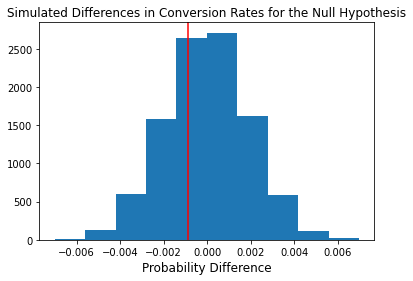

In [26]:
obs_diff = conv_prob_treatment - conv_prob_control
p_diffs = np.asarray(p_diffs)
plt.hist(p_diffs)
plt.title("Simulated Differences in Conversion Rates for the Null Hypothesis", fontsize=12)
plt.xlabel("Probability Difference", fontsize=12)
plt.axvline(obs_diff, color='r');

Proportion of the **p_diffs** are greater than the actual difference observed in ab_data.csv

In [29]:
(p_diffs >= obs_diff).mean()

0.6762

> In order to reject the null hypothesis, the p-value should be below our α level of 0.05 (agreed level of 5% chance of committing a Type I error if the null is true). In our case, the p-value calculated is 0.6, too high for us to be able to reject the null hypothesis. There is no sufficient evidence to say that there is convertion difference between the new and old pages.

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
convert_old, convert_new, n_old, n_new

(6869, 6847, 57324, 57565)

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-0.46197252010144246, 0.677949486533178)

> A z-score is the number of standard deviations from the mean a data point is (obs_diff). The z-score and p-value computed in the previous question agree with the findings in previous parts (p-value == 0.9).

<a id='regression'></a>
## Part III: Regression

`1.` Confirm that the result achieved in the previous A/B test can also be acheived by performing logistic regression.



The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.  First we need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1.0,1,0,1


Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [ ]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

> The p-value calculated here is 0.190. This is because the Logit Regression is based on a two-tailed test. 0.190 is still greater then 0.05 (our $\alpha$), so we still cannot reject our null hypothesis.


> The convert rate may be related to some features of users like nationality, age, gender or specific cultural behavior. Adding additional information about users could reveal hidden value of the new version of the page for specific group of the users.

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows. 

Does it appear that country had an impact on conversion?

In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0.0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0.0,1,1,0
887018,US,2017-01-06 11:09:40.487196,treatment,new_page,0.0,1,1,0
666132,UK,2017-01-19 22:45:47.593706,treatment,new_page,0.0,1,1,0
668810,UK,2017-01-13 16:59:49.226184,treatment,new_page,0.0,1,1,0


In [39]:
# Check what countries are in the new dataset
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [40]:
### Create the necessary dummy variables
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,ca,uk,us
user_id,,,,,,,,,,,
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0.0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0.0,1,1,0,0,1,0
887018,US,2017-01-06 11:09:40.487196,treatment,new_page,0.0,1,1,0,0,0,1
666132,UK,2017-01-19 22:45:47.593706,treatment,new_page,0.0,1,1,0,0,1,0
668810,UK,2017-01-13 16:59:49.226184,treatment,new_page,0.0,1,1,0,0,1,0


In [ ]:
# Train the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'uk', 'us']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 20 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        22:19:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
uk             0.0507      0.028      1.786      0.074      -0.005       0.106
us             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**Answer:** The p-values for the countries are above 0.05, so again we cannot reject the null hypothesis. Countries do not influence significantly differences in the conversion rates.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
# Create additional columns specifying what user/country converted
df_new['us_page'] = df_new['us'] * df_new['ab_page']
df_new['uk_page'] = df_new['uk'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,ca,uk,us,us_page,uk_page
user_id,,,,,,,,,,,,,
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0.0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0.0,1,1,0,0,1,0,0,1
887018,US,2017-01-06 11:09:40.487196,treatment,new_page,0.0,1,1,0,0,0,1,1,0
666132,UK,2017-01-19 22:45:47.593706,treatment,new_page,0.0,1,1,0,0,1,0,0,1
668810,UK,2017-01-13 16:59:49.226184,treatment,new_page,0.0,1,1,0,0,1,0,0,1


In [ ]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'us', 'uk', 'us_page', 'uk_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Sep 2018   Pseudo R-squ.:               3.482e-05
Time:                        22:19:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
us             0.0175      0.038      0.465      0.642      -0.056       0.091
uk             0.0118      0.040      0.296      0.767      -0.066       0.090
us_page        0.0469      0.054      0.872      0.383      -0.059       0.152
uk_page        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

> Looking at p-values for all variables (all higher than 0.05) we can say that interactions between page and country have no significant effects on conversion. 

<a id='conclusions'></a>
## Inference

> The conclusion of the whole study and the general result is that we do not have sufficient evidence to suggest that the new page results in more conversions than the old one.

> Although there could be other variables identified regarding users which could result in rejecting our null hypothesis (and would require additional resources/money and time), the so-far analysis results would bias me toward suggesting to drop the new page as not bringing much value and focus on something else (maybe another brand new page with other features to test).